# Imports

In [1]:
import re
import sys
import os
import torch
import datetime
import numpy as np
import matplotlib.pyplot as plt
import setproctitle, socket, uuid

from argparse import Namespace
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
from warmup_scheduler import GradualWarmupScheduler

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
sys.path.append(os.path.abspath(".."))       # for 'protonet_mnist_add_utils' folder
sys.path.append(os.path.abspath("../.."))    # for 'data' folder
sys.path.append(os.path.abspath("../../..")) # for 'models' and 'datasets' folders

print(sys.path)

['/users-1/eleonora/reasoning-shortcuts/IXShort/shortcut_mitigation/mnist/notebooks', '/users-1/eleonora/anaconda3/envs/r4rr/lib/python38.zip', '/users-1/eleonora/anaconda3/envs/r4rr/lib/python3.8', '/users-1/eleonora/anaconda3/envs/r4rr/lib/python3.8/lib-dynload', '', '/users-1/eleonora/.local/lib/python3.8/site-packages', '/users-1/eleonora/anaconda3/envs/r4rr/lib/python3.8/site-packages', '/users-1/eleonora/reasoning-shortcuts/IXShort/shortcut_mitigation/mnist', '/users-1/eleonora/reasoning-shortcuts/IXShort/shortcut_mitigation', '/users-1/eleonora/reasoning-shortcuts/IXShort']


In [2]:
from models import get_model
from models.mnistdpl import MnistDPL

from datasets import get_dataset

from utils import fprint
from utils.checkpoint import save_model
from utils.status import progress_bar
from utils.dpl_loss import ADDMNIST_DPL
from utils.metrics import evaluate_metrics
from utils.train import convert_to_categories, compute_coverage

# Utilities

In [3]:
def plot_images(images, labels, concepts, n=3):
    """
    Plots the first 3 images from a batch, with their labels and concept annotations.

    Args:
        images (torch.Tensor): Shape [B, 1, 28, 224] - batch of concatenated MNIST digits.
        labels (torch.Tensor): Shape [B, 2] - two binary labels per image.
        concepts (torch.Tensor): Shape [B, 2, 4] - concept annotations per digit.
    """
    fig, axs = plt.subplots(1, n, figsize=(12, 5))

    for i in range(n):
        img = images[i].squeeze(0)  # Shape [28, 224]
        lbl = labels[i].tolist()
        cpt = concepts[i].tolist()

        axs[i].imshow(img, cmap='gray')
        axs[i].axis('off')
        
        axs[i].set_title(f"Labels: {lbl}", fontsize=10)
        axs[i].text(0.5, -0.1,
                    f"Concepts: {cpt}",
                    fontsize=8,
                    ha='center',
                    va='top',
                    transform=axs[i].transAxes)

    plt.tight_layout()
    plt.show()

# Setup

In [4]:
args = Namespace(
    and_op='Godel',
    backbone='conceptizer', 
    batch_size=64, # & ok          
    beta=0.99,                      
    boia_model='ce', 
    boia_ood_knowledge=False, 
    c_sup=1.0, 
    c_sup_ltn=0, 
    checkin=None, 
    checkout=False, 
    count=30, 
    dataset='mnmath',     
    entity='', 
    entropy=False, 
    exp_decay=0.9,                  
    gamma=1e-3,                      
    imp_op='Prod',
    joint=False, 
    lr=0.001,  # & ok                     
    model='mnmathcbm',                
    n_epochs=40,                    
    non_verbose=False, 
    notes=None, 
    or_op='Prod',           
    p=6,                    
    posthoc=False, 
    preprocess=False, 
    proj_name='', 
    project='Reasoning-Shortcuts', 
    seeds=[], 
    splitted=False, 
    task='mnmath', 
    tuning=False, 
    use_ood=False, 
    val_metric='accuracy', 
    validate=False, 
    w_c=1, 
    w_h=0,                       
    w_rec=1, 
    w_sl=10,
    wandb=None, 
    warmup_steps=0, 
    weight_decay=0.0001,  # & ok          
    which_c=[0, 5, 9],
    device=torch.device("cuda"),
    
    seed = 1617,        # 1415, 1617, 1819, || 2021, 2223.
    patience = 15,
    prototypes=False,
)

In [5]:
# logging
args.conf_jobnum = str(uuid.uuid4())
args.conf_timestamp = str(datetime.datetime.now())
args.conf_host = socket.gethostname()

# set job name
setproctitle.setproctitle(
    "{}_{}_{}".format(
        args.model,
        args.buffer_size if "buffer_size" in args else 0,
        args.dataset,
    )
)

# saving
save_folder = "mnmath" 
save_model_name = 'cbm'
save_path = os.path.join("..", "..", 
    "notebooks-outputs-dpl-mnmath", 
    save_folder, 
    "baseline", 
    save_model_name,
    f"standard-baseline"
)
print(f"Save path: {str(save_path)}")

Save path: ../../notebooks-outputs-dpl-mnmath/mnmath/baseline/cbm/standard-baseline


# Data Loading

# Data Import

In [6]:
mnmath_dataset = get_dataset(args)
mnmath_train_loader, mnmath_val_loader, mnmath_test_loader, mnmath_ood_loader = mnmath_dataset.get_data_loaders()
print(mnmath_dataset)
mnmath_dataset.print_stats()

Available datasets: ['mnmath', 'xor', 'clipboia', 'shortmnist', 'restrictedmnist', 'minikandinsky', 'presddoia', 'prekandinsky', 'sddoia', 'clipkandinsky', 'addmnist', 'clipshortmnist', 'boia_original', 'boia_original_embedded', 'clipsddoia', 'boia', 'kandinsky', 'halfmnist']
Loaded datasets in 0.7007741928100586 s.
Len loaders: 
 train: 1000 
 val: 200
 len test: 300
## Statistics ##
Train samples 1000
Validation samples 200
Test samples 300
Test OOD samples 300


## Data Inspection

*See some statistics about the dataset*

In [7]:
first_label_1 = 0
second_label_1 = 0
both_labels_1 = 0
total = 0

for data in mnmath_train_loader:
    _, labels, _ = data  # labels shape: [batch_size, 2]
    
    total += labels.size(0)
    first_label_1 += (labels[:, 0] == 1).sum().item()
    second_label_1 += (labels[:, 1] == 1).sum().item()
    both_labels_1 += ((labels[:, 0] == 1) & (labels[:, 1] == 1)).sum().item()

print(f"Total samples: {total}")
print(f"First label == 1: {first_label_1} ({100 * first_label_1 / total:.2f}%)")
print(f"Second label == 1: {second_label_1} ({100 * second_label_1 / total:.2f}%)")
print(f"Both labels == 1: {both_labels_1} ({100 * both_labels_1 / total:.2f}%)")

Total samples: 1000
First label == 1: 437 (43.70%)
Second label == 1: 125 (12.50%)
Both labels == 1: 63 (6.30%)


*Plotting some examples*

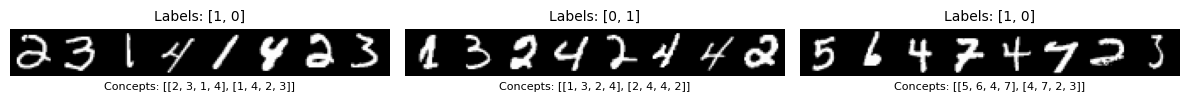

In [8]:
for data in mnmath_train_loader:
    images, labels, concepts = data  # shapes: [32, 1, 28, 224], [32, 2], [32, 2, 4]
    
    # Filter indices where either label[0] or label[1] is 1
    mask = (labels[:, 0] == 1) | (labels[:, 1] == 1)
    indices = torch.nonzero(mask).squeeze()

    if len(indices) >= 3:
        selected_images = images[indices[:3]]
        selected_labels = labels[indices[:3]]
        selected_concepts = concepts[indices[:3]]

        plot_images(selected_images, selected_labels, selected_concepts)
    else:
        print("Not enough samples with at least one positive label in this batch.")
    
    break  # only process one batch

# Model

In [9]:
n_images, c_split = mnmath_dataset.get_split()
encoder, decoder = mnmath_dataset.get_backbone()
model = get_model(args, encoder, decoder, n_images, c_split)
loss = model.get_loss(args)
model.start_optim(args)

print("Using Dataset: ", mnmath_dataset)
print("Using backbone: ", encoder)
print("Using Model: ", model)
print("Using Loss: ", loss)

Available models: ['promnistltn', 'sddoiann', 'kandnn', 'sddoiadpl', 'sddoialtn', 'presddoiadpl', 'boiann', 'mnistclip', 'prokanddpl', 'promnistdpl', 'xornn', 'mnistnn', 'mnistslrec', 'kandpreprocess', 'kandsl', 'kandsloneembedding', 'prokandltn', 'kandcbm', 'prokandsl', 'boiacbm', 'kanddpl', 'kandltn', 'xorcbm', 'sddoiaclip', 'xordpl', 'promnmathdpl', 'sddoiacbm', 'mnistltnrec', 'mnmathcbm', 'mnmathdpl', 'kandclip', 'minikanddpl', 'mnistdpl', 'mnistltn', 'boiadpl', 'boialtn', 'prokandsloneembedding', 'mnistpcbmdpl', 'mnistcbm', 'probddoiadpl', 'mnistpcbmsl', 'mnistpcbmltn', 'mnistsl', 'mnistdplrec', 'cvae', 'cext', 'mnmathnn', 'promnistsl']
Using Dataset:  <datasets.mnmath.MNMATH object at 0x7f27c9f96970>
Using backbone:  MNISTSingleEncoder(
  (enc_block_1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc_block_2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc_block_3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)

# Training

## Main Loop

In [10]:
def train(model:MnistDPL,
        train_loader:DataLoader,
        val_loader:DataLoader,
        _loss: ADDMNIST_DPL, 
        args,
        save_folder,
        debug=False):
    
    # for full reproducibility
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(args.seed)
    torch.backends.cudnn.enabled = False
    
    best_f1 = 0.0
    epochs_no_improve = 0   # for early stopping

    model.to(model.device)

    # get the data loaders
    scheduler = torch.optim.lr_scheduler.ExponentialLR(model.opt, args.exp_decay)
    w_scheduler = None
    if args.warmup_steps > 0:   w_scheduler = GradualWarmupScheduler(model.opt, 1.0, args.warmup_steps)

    fprint("\n--- Start of Training ---\n")

    # default for warm-up
    model.opt.zero_grad()
    model.opt.step()

    # & FOR EACH EPOCH
    for epoch in range(args.n_epochs):
        model.train()

        # ys are the predictions of the model, y_true are the true labels, cs are the predictions of the concepts, cs_true are the true concepts
        ys, y_true, cs, cs_true = None, None, None, None
        # & FOR EACH BATCH
        for i, data in enumerate(train_loader):

            images, labels, concepts = data
            images, labels, concepts = (
                images.to(model.device),    # input IMAGES
                labels.to(model.device),    # ground truth LABELS
                concepts.to(model.device),  # ground truth CONCEPTS
            )

            # ^ forward pass 
            out_dict = model(images)

            ''' Enrich the out_dict with the ground truth labels and concepts '''
            out_dict.update({"LABELS": labels, "CONCEPTS": concepts})

            ''' Extract the predicted concepts for the first image in the batch '''
            model.opt.zero_grad()
            loss, losses = _loss(out_dict, args)
            loss.backward()
            model.opt.step()
            
            if ys is None:  # first iteration
                ys = out_dict["YS"]
                y_true = out_dict["LABELS"]
                cs = out_dict["pCS"]
                cs_true = out_dict["CONCEPTS"]
            else:           # all other iterations
                ys = torch.concatenate((ys, out_dict["YS"]), dim=0)
                y_true = torch.concatenate((y_true, out_dict["LABELS"]), dim=0)
                cs = torch.concatenate((cs, out_dict["pCS"]), dim=0)
                cs_true = torch.concatenate((cs_true, out_dict["CONCEPTS"]), dim=0)

            if i % 10 == 0:
                progress_bar(i, len(train_loader) - 9, epoch, loss.item())


        print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
        print("End of epoch ", epoch)
        print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
        print()
        
        # ^ enter the evaluation phase
        model.eval()
        tloss, cacc, yacc, f1_y, f1_c = evaluate_metrics(model, val_loader, args)

        # update the (warmup) scheduler at end of the epoch
        if epoch < args.warmup_steps:
            w_scheduler.step()
        else:
            scheduler.step()
            if hasattr(_loss, "grade"):
                _loss.update_grade(epoch)

        ### LOGGING ###
        fprint("  ACC C", cacc, "  ACC Y", yacc, "F1 Y", f1_y, "F1 C", f1_c)
        print()

        if not args.tuning and f1_y > best_f1:
            print("Saving...")
            # Update best F1 score
            best_f1 = f1_y
            epochs_no_improve = 0

            # Save the best model
            torch.save(model.state_dict(), save_folder)
            print(f"Saved best model with F1 score: {best_f1}")
            print()

        elif f1_y <= best_f1:
            epochs_no_improve += 1

        if epochs_no_improve >= args.patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

    print("End of training")
    return best_f1

## Run Training

In [11]:
f1_scores = dict()
print(f"*** Training model with seed {args.seed}")
print("Chosen device:", model.device)
print("Save path for this model: ", save_path)
if not os.path.exists(save_path): os.makedirs(save_path, exist_ok=True)
save_folder = os.path.join(save_path, f"{save_model_name}_{args.seed}.pth")
print("Saving in folder: ", save_folder)

best_f1 = train(model=model,
    train_loader=mnmath_train_loader,
    val_loader=mnmath_val_loader,
    _loss=loss, 
    args=args,
    save_folder=save_folder
)
f1_scores[args.seed] = best_f1
save_model(model, args, args.seed)  # save the model parameters

best_weight_seed = max(f1_scores, key=f1_scores.get)
print(f"Best weight and seed combination: {best_weight_seed} with F1 score: {f1_scores[best_weight_seed]}")

*** Training model with seed 1617
Chosen device: cuda
Save path for this model:  ../../notebooks-outputs-dpl-mnmath/mnmath/baseline/cbm/standard-baseline
Saving in folder:  ../../notebooks-outputs-dpl-mnmath/mnmath/baseline/cbm/standard-baseline/cbm_1617.pth

--- Start of Training ---



[ 07-20 | 13:15 ] epoch 0: |███████┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| loss: 0.75695115

Concept supervision loss 2.3010823726654053
Concept supervision loss 2.3091657161712646
Concept supervision loss 2.3119754791259766
Concept supervision loss 2.338151454925537
Concept supervision loss 2.362440586090088
Concept supervision loss 2.3816699981689453
Concept supervision loss 2.409494638442993
Concept supervision loss 2.3928451538085938
Concept supervision loss 2.2730672359466553
Concept supervision loss 2.172727346420288


[ 07-20 | 13:15 ] epoch 0: |██████████████████████████████████████████████████| loss: 0.54817134

Concept supervision loss 2.1451847553253174
Concept supervision loss 2.140617609024048
Concept supervision loss 2.2721760272979736
Concept supervision loss 2.2637438774108887
Concept supervision loss 2.32962965965271
Concept supervision loss 2.4375336170196533
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 28.125   ACC Y 57.6171875 F1 Y 55.826466665891274 F1 C 7.317073170731707


[ 07-20 | 13:15 ] epoch 1: |███████┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| loss: 0.58245641


Saving...
Saved best model with F1 score: 55.826466665891274

Concept supervision loss 2.456211566925049
Concept supervision loss 2.4594602584838867
Concept supervision loss 2.460219144821167
Concept supervision loss 2.460793972015381
Concept supervision loss 2.4609994888305664
Concept supervision loss 2.4609837532043457
Concept supervision loss 2.4610912799835205
Concept supervision loss 2.461113214492798
Concept supervision loss 2.461122751235962
Concept supervision loss 2.4611237049102783
Concept supervision loss 2.4611270427703857


[ 07-20 | 13:15 ] epoch 1: |██████████████████████████████████████████████████| loss: 0.50463641

Concept supervision loss 2.4611268043518066
Concept supervision loss 2.4611270427703857
Concept supervision loss 2.461127281188965
Concept supervision loss 2.461127519607544
Concept supervision loss 2.4611268043518066
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  1
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 28.125   ACC Y 75.9765625 F1 Y 64.54960748384717 F1 C 7.317073170731707


[ 07-20 | 13:15 ] epoch 2: |███████┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| loss: 0.5041576


Saving...
Saved best model with F1 score: 64.54960748384717

Concept supervision loss 2.4611268043518066
Concept supervision loss 2.461127281188965
Concept supervision loss 2.461127519607544
Concept supervision loss 2.461127519607544
Concept supervision loss 2.461127281188965
Concept supervision loss 2.461127281188965
Concept supervision loss 2.461127281188965
Concept supervision loss 2.461127281188965
Concept supervision loss 2.461127281188965
Concept supervision loss 2.461127519607544
Concept supervision loss 2.461127281188965


[ 07-20 | 13:15 ] epoch 2: |██████████████████████████████████████████████████| loss: 0.49297154

Concept supervision loss 2.461127281188965
Concept supervision loss 2.461127281188965
Concept supervision loss 2.461127281188965
Concept supervision loss 2.461127281188965
Concept supervision loss 2.4611268043518066
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  2
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 28.125   ACC Y 79.6875 F1 Y 71.87399661174223 F1 C 7.317073170731707


[ 07-20 | 13:16 ] epoch 3: |███████┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| loss: 0.40271127


Saving...
Saved best model with F1 score: 71.87399661174223

Concept supervision loss 2.4611270427703857
Concept supervision loss 2.4611270427703857
Concept supervision loss 2.461127519607544
Concept supervision loss 2.461127281188965
Concept supervision loss 2.4611270427703857
Concept supervision loss 2.461127281188965
Concept supervision loss 2.4611270427703857
Concept supervision loss 2.461127281188965
Concept supervision loss 2.461127519607544
Concept supervision loss 2.461127281188965
Concept supervision loss 2.461127281188965


[ 07-20 | 13:16 ] epoch 3: |██████████████████████████████████████████████████| loss: 0.51758879

Concept supervision loss 2.461127281188965
Concept supervision loss 2.461127281188965
Concept supervision loss 2.461127281188965
Concept supervision loss 2.461127281188965
Concept supervision loss 2.4611270427703857
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  3
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 28.125   ACC Y 75.5859375 F1 Y 71.33150114295908 F1 C 7.317073170731707


[ 07-20 | 13:16 ] epoch 4: |███████┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| loss: 0.41117793


Concept supervision loss 2.461127519607544
Concept supervision loss 2.461127281188965
Concept supervision loss 2.4611270427703857
Concept supervision loss 2.4611268043518066
Concept supervision loss 2.4611270427703857
Concept supervision loss 2.461127519607544
Concept supervision loss 2.461127281188965
Concept supervision loss 2.4607889652252197
Concept supervision loss 2.4611194133758545
Concept supervision loss 2.4611170291900635
Concept supervision loss 2.460170030593872


[ 07-20 | 13:16 ] epoch 4: |██████████████████████████████████████████████████| loss: 0.31492293

Concept supervision loss 2.4611246585845947
Concept supervision loss 2.4602506160736084
Concept supervision loss 2.461120367050171
Concept supervision loss 2.460381507873535
Concept supervision loss 2.4606337547302246
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  4
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 6.103515625   ACC Y 84.5703125 F1 Y 81.6918839929655 F1 C 2.204030345066107


[ 07-20 | 13:16 ] epoch 5: |███████┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| loss: 0.33927852


Saving...
Saved best model with F1 score: 81.6918839929655

Concept supervision loss 2.458737373352051
Concept supervision loss 2.4589807987213135
Concept supervision loss 2.456183671951294
Concept supervision loss 2.458235502243042
Concept supervision loss 2.457610607147217
Concept supervision loss 2.457021474838257
Concept supervision loss 2.4596707820892334
Concept supervision loss 2.4605700969696045
Concept supervision loss 2.4516639709472656
Concept supervision loss 2.4586539268493652
Concept supervision loss 2.459001064300537


[ 07-20 | 13:16 ] epoch 5: |██████████████████████████████████████████████████| loss: 0.33181667

Concept supervision loss 2.459317207336426
Concept supervision loss 2.4564714431762695
Concept supervision loss 2.460301399230957
Concept supervision loss 2.457535743713379
Concept supervision loss 2.4591517448425293
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  5
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 7.91015625   ACC Y 86.71875 F1 Y 84.43887089350284 F1 C 5.687763684197316


[ 07-20 | 13:16 ] epoch 6: |███████┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| loss: 0.17036456


Saving...
Saved best model with F1 score: 84.43887089350284

Concept supervision loss 2.4547526836395264
Concept supervision loss 2.458902597427368
Concept supervision loss 2.4552953243255615
Concept supervision loss 2.456550359725952
Concept supervision loss 2.459947347640991
Concept supervision loss 2.4586222171783447
Concept supervision loss 2.4581105709075928
Concept supervision loss 2.4580321311950684
Concept supervision loss 2.4587416648864746
Concept supervision loss 2.457073926925659
Concept supervision loss 2.4559454917907715


[ 07-20 | 13:16 ] epoch 6: |██████████████████████████████████████████████████| loss: 0.17476627

Concept supervision loss 2.4609243869781494
Concept supervision loss 2.4601619243621826
Concept supervision loss 2.4586246013641357
Concept supervision loss 2.4582695960998535
Concept supervision loss 2.4571588039398193
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  6
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 24.169921875   ACC Y 91.40625 F1 Y 89.8806107774873 F1 C 9.18079096045198


[ 07-20 | 13:16 ] epoch 7: |███████┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| loss: 0.20739403


Saving...
Saved best model with F1 score: 89.8806107774873

Concept supervision loss 2.4579477310180664
Concept supervision loss 2.461103916168213
Concept supervision loss 2.461010217666626
Concept supervision loss 2.4611263275146484
Concept supervision loss 2.4611215591430664
Concept supervision loss 2.461106538772583
Concept supervision loss 2.459434747695923
Concept supervision loss 2.4598963260650635
Concept supervision loss 2.4611244201660156
Concept supervision loss 2.461050033569336
Concept supervision loss 2.4609930515289307


[ 07-20 | 13:16 ] epoch 7: |██████████████████████████████████████████████████| loss: 0.2031928

Concept supervision loss 2.4611144065856934
Concept supervision loss 2.4596705436706543
Concept supervision loss 2.46107816696167
Concept supervision loss 2.4593191146850586
Concept supervision loss 2.4611265659332275
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  7
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 26.416015625   ACC Y 93.1640625 F1 Y 92.05187292563838 F1 C 10.626234711510293


[ 07-20 | 13:16 ] epoch 8: |███████┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| loss: 0.0943484


Saving...
Saved best model with F1 score: 92.05187292563838

Concept supervision loss 2.4610636234283447
Concept supervision loss 2.4607858657836914
Concept supervision loss 2.460127592086792
Concept supervision loss 2.460623264312744
Concept supervision loss 2.459552049636841
Concept supervision loss 2.460975170135498
Concept supervision loss 2.461125612258911
Concept supervision loss 2.4611270427703857
Concept supervision loss 2.4611258506774902
Concept supervision loss 2.460047960281372
Concept supervision loss 2.4583663940429688


[ 07-20 | 13:16 ] epoch 8: |██████████████████████████████████████████████████| loss: 0.0994226

Concept supervision loss 2.459766149520874
Concept supervision loss 2.461103916168213
Concept supervision loss 2.4602980613708496
Concept supervision loss 2.459319829940796
Concept supervision loss 2.4559733867645264
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  8
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 26.07421875   ACC Y 93.359375 F1 Y 92.15594534109434 F1 C 11.256584899437504


[ 07-20 | 13:16 ] epoch 9: |███████┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| loss: 0.11124334


Saving...
Saved best model with F1 score: 92.15594534109434

Concept supervision loss 2.460979700088501
Concept supervision loss 2.4609811305999756
Concept supervision loss 2.4594719409942627
Concept supervision loss 2.4589426517486572
Concept supervision loss 2.457507371902466
Concept supervision loss 2.4603898525238037
Concept supervision loss 2.459773063659668
Concept supervision loss 2.4588375091552734
Concept supervision loss 2.4610698223114014
Concept supervision loss 2.4608263969421387
Concept supervision loss 2.4595131874084473


[ 07-20 | 13:16 ] epoch 9: |██████████████████████████████████████████████████| loss: 0.05730849

Concept supervision loss 2.4592037200927734
Concept supervision loss 2.459711790084839
Concept supervision loss 2.460606813430786
Concept supervision loss 2.459284782409668
Concept supervision loss 2.4596917629241943
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  9
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 29.052734375   ACC Y 94.53125 F1 Y 93.7973223602971 F1 C 13.634440516440712


[ 07-20 | 13:16 ] epoch 10: |███████┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| loss: 0.0975824


Saving...
Saved best model with F1 score: 93.7973223602971

Concept supervision loss 2.4610791206359863
Concept supervision loss 2.458951473236084
Concept supervision loss 2.461014747619629
Concept supervision loss 2.460157632827759
Concept supervision loss 2.4575352668762207
Concept supervision loss 2.458946466445923
Concept supervision loss 2.45566725730896
Concept supervision loss 2.4610202312469482
Concept supervision loss 2.4582228660583496
Concept supervision loss 2.4587907791137695
Concept supervision loss 2.458895206451416


[ 07-20 | 13:16 ] epoch 10: |██████████████████████████████████████████████████| loss: 0.06179733

Concept supervision loss 2.4589648246765137
Concept supervision loss 2.4611167907714844
Concept supervision loss 2.459315776824951
Concept supervision loss 2.458892345428467
Concept supervision loss 2.4611268043518066
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  10
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 29.150390625   ACC Y 95.1171875 F1 Y 94.44427847134168 F1 C 13.224612115124398


[ 07-20 | 13:16 ] epoch 11: |███████┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| loss: 0.06050844


Saving...
Saved best model with F1 score: 94.44427847134168

Concept supervision loss 2.4584765434265137
Concept supervision loss 2.4609758853912354
Concept supervision loss 2.4593145847320557
Concept supervision loss 2.460202217102051
Concept supervision loss 2.4576375484466553
Concept supervision loss 2.4609737396240234
Concept supervision loss 2.4593236446380615
Concept supervision loss 2.460493803024292
Concept supervision loss 2.4604103565216064
Concept supervision loss 2.460202932357788


[ 07-20 | 13:16 ] epoch 11: |██████████████████████████████████████████████████| loss: 0.03794545

Concept supervision loss 2.461103916168213
Concept supervision loss 2.459780693054199
Concept supervision loss 2.461090564727783
Concept supervision loss 2.4611260890960693
Concept supervision loss 2.458594799041748
Concept supervision loss 2.461097478866577
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  11
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 30.37109375   ACC Y 95.5078125 F1 Y 94.84679916250036 F1 C 14.661630518430105


[ 07-20 | 13:16 ] epoch 12: |███████┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| loss: 0.138243


Saving...
Saved best model with F1 score: 94.84679916250036

Concept supervision loss 2.4590961933135986
Concept supervision loss 2.460865020751953
Concept supervision loss 2.4599668979644775
Concept supervision loss 2.4581658840179443
Concept supervision loss 2.458300828933716
Concept supervision loss 2.458998441696167
Concept supervision loss 2.461016893386841
Concept supervision loss 2.4611268043518066
Concept supervision loss 2.461127281188965
Concept supervision loss 2.4611258506774902
Concept supervision loss 2.457571268081665


[ 07-20 | 13:16 ] epoch 12: |██████████████████████████████████████████████████| loss: 0.08280921

Concept supervision loss 2.460855484008789
Concept supervision loss 2.4610488414764404
Concept supervision loss 2.460010051727295
Concept supervision loss 2.4611263275146484
Concept supervision loss 2.4608845710754395
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  12
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 30.078125   ACC Y 94.921875 F1 Y 94.25088497512442 F1 C 14.544352694132431


[ 07-20 | 13:16 ] epoch 13: |███████┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| loss: 0.04760964


Concept supervision loss 2.4610788822174072
Concept supervision loss 2.4591622352600098
Concept supervision loss 2.459367275238037
Concept supervision loss 2.4610259532928467
Concept supervision loss 2.4594368934631348
Concept supervision loss 2.461008310317993
Concept supervision loss 2.4610674381256104
Concept supervision loss 2.460131883621216
Concept supervision loss 2.4608049392700195
Concept supervision loss 2.4603519439697266
Concept supervision loss 2.4578843116760254


[ 07-20 | 13:16 ] epoch 13: |██████████████████████████████████████████████████| loss: 0.05473768

Concept supervision loss 2.4611270427703857
Concept supervision loss 2.4578168392181396
Concept supervision loss 2.4610111713409424
Concept supervision loss 2.45985746383667
Concept supervision loss 2.4589626789093018
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  13
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 29.345703125   ACC Y 95.703125 F1 Y 95.13609183772402 F1 C 13.768018169961097


[ 07-20 | 13:16 ] epoch 14: |███████┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| loss: 0.0172357


Saving...
Saved best model with F1 score: 95.13609183772402

Concept supervision loss 2.459986448287964
Concept supervision loss 2.4609696865081787
Concept supervision loss 2.4604039192199707
Concept supervision loss 2.457927942276001
Concept supervision loss 2.4592466354370117
Concept supervision loss 2.460800886154175
Concept supervision loss 2.461106061935425
Concept supervision loss 2.457998275756836
Concept supervision loss 2.458503484725952


[ 07-20 | 13:16 ] epoch 14: |██████████████████████████████████████████████████| loss: 0.03308785

Concept supervision loss 2.4590330123901367
Concept supervision loss 2.4574246406555176
Concept supervision loss 2.460650682449341
Concept supervision loss 2.4608287811279297
Concept supervision loss 2.4611270427703857
Concept supervision loss 2.4572815895080566
Concept supervision loss 2.4611268043518066
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  14
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 29.78515625   ACC Y 96.484375 F1 Y 96.00065483902344 F1 C 13.618519432919642


[ 07-20 | 13:16 ] epoch 15: |███████┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| loss: 0.06434783


Saving...
Saved best model with F1 score: 96.00065483902344

Concept supervision loss 2.4578371047973633
Concept supervision loss 2.4607644081115723
Concept supervision loss 2.458681583404541
Concept supervision loss 2.460076332092285
Concept supervision loss 2.4611258506774902
Concept supervision loss 2.4611270427703857
Concept supervision loss 2.4576101303100586
Concept supervision loss 2.4611260890960693
Concept supervision loss 2.458425998687744
Concept supervision loss 2.4568371772766113
Concept supervision loss 2.46108341217041


[ 07-20 | 13:16 ] epoch 15: |██████████████████████████████████████████████████| loss: 0.03413681

Concept supervision loss 2.459268093109131
Concept supervision loss 2.461127281188965
Concept supervision loss 2.4596521854400635
Concept supervision loss 2.457923412322998
Concept supervision loss 2.4601354598999023
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  15
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 30.419921875   ACC Y 96.09375 F1 Y 95.56342556191137 F1 C 14.522699486706491


[ 07-20 | 13:16 ] epoch 16: |███████┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| loss: 0.01741644


Concept supervision loss 2.4603848457336426
Concept supervision loss 2.4609873294830322
Concept supervision loss 2.460214376449585
Concept supervision loss 2.4610414505004883
Concept supervision loss 2.4611263275146484
Concept supervision loss 2.459641456604004
Concept supervision loss 2.4597091674804688
Concept supervision loss 2.461127281188965
Concept supervision loss 2.4588260650634766
Concept supervision loss 2.459050178527832
Concept supervision loss 2.4604756832122803


[ 07-20 | 13:16 ] epoch 16: |██████████████████████████████████████████████████| loss: 0.02043585

Concept supervision loss 2.4610655307769775
Concept supervision loss 2.4609172344207764
Concept supervision loss 2.458993434906006
Concept supervision loss 2.4597132205963135
Concept supervision loss 2.4610559940338135
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  16
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 30.76171875   ACC Y 97.0703125 F1 Y 96.66617873733978 F1 C 14.859421175149826


[ 07-20 | 13:16 ] epoch 17: |███████┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| loss: 0.01924615


Saving...
Saved best model with F1 score: 96.66617873733978

Concept supervision loss 2.461125373840332
Concept supervision loss 2.4607174396514893
Concept supervision loss 2.459378957748413
Concept supervision loss 2.458268642425537
Concept supervision loss 2.4600024223327637
Concept supervision loss 2.4599733352661133
Concept supervision loss 2.4585134983062744
Concept supervision loss 2.460861921310425
Concept supervision loss 2.455551862716675
Concept supervision loss 2.4604740142822266
Concept supervision loss 2.4596636295318604


[ 07-20 | 13:16 ] epoch 17: |██████████████████████████████████████████████████| loss: 0.01536698

Concept supervision loss 2.4611079692840576
Concept supervision loss 2.461125612258911
Concept supervision loss 2.460581064224243
Concept supervision loss 2.460520029067993
Concept supervision loss 2.461120128631592
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  17
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 30.322265625   ACC Y 96.2890625 F1 Y 95.78079109687206 F1 C 14.345041816009557


[ 07-20 | 13:16 ] epoch 18: |███████┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| loss: 0.05076874


Concept supervision loss 2.4600584506988525
Concept supervision loss 2.460263252258301
Concept supervision loss 2.460794687271118
Concept supervision loss 2.4610326290130615
Concept supervision loss 2.4611268043518066
Concept supervision loss 2.461077928543091
Concept supervision loss 2.4564146995544434
Concept supervision loss 2.4606173038482666
Concept supervision loss 2.4588773250579834
Concept supervision loss 2.4578466415405273
Concept supervision loss 2.4573991298675537


[ 07-20 | 13:16 ] epoch 18: |██████████████████████████████████████████████████| loss: 0.03991816

Concept supervision loss 2.4611074924468994
Concept supervision loss 2.459834098815918
Concept supervision loss 2.457587242126465
Concept supervision loss 2.4586422443389893
Concept supervision loss 2.4609854221343994
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  18
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 30.322265625   ACC Y 96.6796875 F1 Y 96.22066886401942 F1 C 14.375213536890183


[ 07-20 | 13:16 ] epoch 19: |███████┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| loss: 0.05007156


Concept supervision loss 2.461088180541992
Concept supervision loss 2.4596107006073
Concept supervision loss 2.460897207260132
Concept supervision loss 2.4588418006896973
Concept supervision loss 2.4609436988830566
Concept supervision loss 2.4589273929595947
Concept supervision loss 2.460967540740967
Concept supervision loss 2.458691358566284
Concept supervision loss 2.4599900245666504
Concept supervision loss 2.459460973739624
Concept supervision loss 2.4609549045562744


[ 07-20 | 13:16 ] epoch 19: |██████████████████████████████████████████████████| loss: 0.02373371

Concept supervision loss 2.4597198963165283
Concept supervision loss 2.460676670074463
Concept supervision loss 2.460197687149048
Concept supervision loss 2.461090326309204
Concept supervision loss 2.456719160079956
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  19
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 30.517578125   ACC Y 96.6796875 F1 Y 96.23618168821471 F1 C 14.504281949934123


[ 07-20 | 13:16 ] epoch 20: |███████┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| loss: 0.03870041


Concept supervision loss 2.458592653274536
Concept supervision loss 2.461127281188965
Concept supervision loss 2.460310220718384
Concept supervision loss 2.4591546058654785
Concept supervision loss 2.459836959838867
Concept supervision loss 2.460596799850464
Concept supervision loss 2.4588518142700195
Concept supervision loss 2.461111307144165
Concept supervision loss 2.4592394828796387
Concept supervision loss 2.4607512950897217
Concept supervision loss 2.4599475860595703


[ 07-20 | 13:16 ] epoch 20: |██████████████████████████████████████████████████| loss: 0.06486561

Concept supervision loss 2.460944175720215
Concept supervision loss 2.4611268043518066
Concept supervision loss 2.4611120223999023
Concept supervision loss 2.4606359004974365
Concept supervision loss 2.4598495960235596
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  20
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 30.76171875   ACC Y 97.0703125 F1 Y 96.66617873733978 F1 C 14.701759005201259


[ 07-20 | 13:16 ] epoch 21: |███████┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| loss: 0.03557383


Concept supervision loss 2.461102247238159
Concept supervision loss 2.459810256958008
Concept supervision loss 2.4610354900360107
Concept supervision loss 2.461068630218506
Concept supervision loss 2.461117744445801
Concept supervision loss 2.4611268043518066
Concept supervision loss 2.459608316421509
Concept supervision loss 2.461019515991211
Concept supervision loss 2.4611241817474365
Concept supervision loss 2.4570488929748535
Concept supervision loss 2.4597325325012207


[ 07-20 | 13:16 ] epoch 21: |██████████████████████████████████████████████████| loss: 0.04734617

Concept supervision loss 2.4596245288848877
Concept supervision loss 2.4611263275146484
Concept supervision loss 2.456869602203369
Concept supervision loss 2.4611270427703857
Concept supervision loss 2.4590280055999756
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  21
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 30.6640625   ACC Y 97.0703125 F1 Y 96.66617873733978 F1 C 14.59719468311669


[ 07-20 | 13:16 ] epoch 22: |███████┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| loss: 0.02046132


Concept supervision loss 2.4608325958251953
Concept supervision loss 2.461115598678589
Concept supervision loss 2.4583303928375244
Concept supervision loss 2.4607415199279785
Concept supervision loss 2.4602420330047607
Concept supervision loss 2.4611270427703857
Concept supervision loss 2.459218978881836
Concept supervision loss 2.4599969387054443
Concept supervision loss 2.4611122608184814
Concept supervision loss 2.460336208343506
Concept supervision loss 2.460921049118042


[ 07-20 | 13:16 ] epoch 22: |██████████████████████████████████████████████████| loss: 0.02169556

Concept supervision loss 2.459968090057373
Concept supervision loss 2.4611175060272217
Concept supervision loss 2.461125373840332
Concept supervision loss 2.4608676433563232
Concept supervision loss 2.4611265659332275
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  22
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 30.908203125   ACC Y 96.6796875 F1 Y 96.22066886401942 F1 C 14.788245462402767


[ 07-20 | 13:16 ] epoch 23: |███████┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| loss: 0.01690689


Concept supervision loss 2.460963010787964
Concept supervision loss 2.461092472076416
Concept supervision loss 2.4608051776885986
Concept supervision loss 2.4606354236602783
Concept supervision loss 2.4598536491394043
Concept supervision loss 2.459672212600708
Concept supervision loss 2.4610981941223145
Concept supervision loss 2.459320068359375
Concept supervision loss 2.4596359729766846
Concept supervision loss 2.4611153602600098
Concept supervision loss 2.4611265659332275


[ 07-20 | 13:16 ] epoch 23: |██████████████████████████████████████████████████| loss: 0.03536089

Concept supervision loss 2.4610755443573
Concept supervision loss 2.459388256072998
Concept supervision loss 2.460767984390259
Concept supervision loss 2.459487199783325
Concept supervision loss 2.461123466491699
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  23
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 30.76171875   ACC Y 97.0703125 F1 Y 96.67874865306933 F1 C 14.607996426178243


[ 07-20 | 13:16 ] epoch 24: |███████┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| loss: 0.02515485


Saving...
Saved best model with F1 score: 96.67874865306933

Concept supervision loss 2.4596056938171387
Concept supervision loss 2.461116075515747
Concept supervision loss 2.460840940475464
Concept supervision loss 2.4611170291900635
Concept supervision loss 2.4590981006622314
Concept supervision loss 2.460866689682007
Concept supervision loss 2.457195281982422
Concept supervision loss 2.4610912799835205
Concept supervision loss 2.4611270427703857
Concept supervision loss 2.459932565689087
Concept supervision loss 2.4607913494110107


[ 07-20 | 13:16 ] epoch 24: |██████████████████████████████████████████████████| loss: 0.01045293

Concept supervision loss 2.458768367767334
Concept supervision loss 2.459463119506836
Concept supervision loss 2.461038112640381
Concept supervision loss 2.4579544067382812
Concept supervision loss 2.456542730331421
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  24
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 31.494140625   ACC Y 96.484375 F1 Y 96.00080512186804 F1 C 15.05670903397279


[ 07-20 | 13:16 ] epoch 25: |███████┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| loss: 0.01759462


Concept supervision loss 2.4592161178588867
Concept supervision loss 2.459843397140503
Concept supervision loss 2.459172487258911
Concept supervision loss 2.460408926010132
Concept supervision loss 2.460294485092163
Concept supervision loss 2.4610915184020996
Concept supervision loss 2.4604341983795166
Concept supervision loss 2.460681438446045
Concept supervision loss 2.4610695838928223
Concept supervision loss 2.459280014038086
Concept supervision loss 2.4611265659332275


[ 07-20 | 13:16 ] epoch 25: |██████████████████████████████████████████████████| loss: 0.04070654

Concept supervision loss 2.4611270427703857
Concept supervision loss 2.45974063873291
Concept supervision loss 2.460954427719116
Concept supervision loss 2.4594666957855225
Concept supervision loss 2.461125612258911
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  25
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 30.712890625   ACC Y 97.0703125 F1 Y 96.66617873733978 F1 C 14.564953922846493


[ 07-20 | 13:16 ] epoch 26: |███████┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| loss: 0.03514478


Concept supervision loss 2.460847854614258
Concept supervision loss 2.461066246032715
Concept supervision loss 2.4600648880004883
Concept supervision loss 2.458232879638672
Concept supervision loss 2.4611268043518066
Concept supervision loss 2.4592771530151367
Concept supervision loss 2.4607064723968506
Concept supervision loss 2.4607346057891846
Concept supervision loss 2.4607017040252686
Concept supervision loss 2.4604663848876953
Concept supervision loss 2.460742473602295


[ 07-20 | 13:16 ] epoch 26: |██████████████████████████████████████████████████| loss: 0.01049069

Concept supervision loss 2.461083173751831
Concept supervision loss 2.4611122608184814
Concept supervision loss 2.45944881439209
Concept supervision loss 2.4611270427703857
Concept supervision loss 2.4600319862365723
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  26
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 30.615234375   ACC Y 96.6796875 F1 Y 96.22066886401942 F1 C 14.509195017489581


[ 07-20 | 13:16 ] epoch 27: |███████┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| loss: 0.01885511


Concept supervision loss 2.4572696685791016
Concept supervision loss 2.4597830772399902
Concept supervision loss 2.4593350887298584
Concept supervision loss 2.459181308746338
Concept supervision loss 2.4611175060272217
Concept supervision loss 2.460939407348633
Concept supervision loss 2.4611217975616455
Concept supervision loss 2.4609267711639404
Concept supervision loss 2.458935260772705
Concept supervision loss 2.4594666957855225
Concept supervision loss 2.4580466747283936


[ 07-20 | 13:16 ] epoch 27: |██████████████████████████████████████████████████| loss: 0.02205964

Concept supervision loss 2.460733413696289
Concept supervision loss 2.4611270427703857
Concept supervision loss 2.460148811340332
Concept supervision loss 2.461120843887329
Concept supervision loss 2.458662509918213
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  27
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 30.46875   ACC Y 97.0703125 F1 Y 96.66617873733978 F1 C 14.340410720501218


[ 07-20 | 13:16 ] epoch 28: |███████┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| loss: 0.02393032


Concept supervision loss 2.460273265838623
Concept supervision loss 2.461054801940918
Concept supervision loss 2.460859775543213
Concept supervision loss 2.4599406719207764
Concept supervision loss 2.46111798286438
Concept supervision loss 2.4611270427703857
Concept supervision loss 2.4609134197235107
Concept supervision loss 2.459373950958252
Concept supervision loss 2.460066795349121
Concept supervision loss 2.459505081176758
Concept supervision loss 2.460991382598877


[ 07-20 | 13:16 ] epoch 28: |██████████████████████████████████████████████████| loss: 0.0467147

Concept supervision loss 2.4591224193573
Concept supervision loss 2.460566759109497
Concept supervision loss 2.459028720855713
Concept supervision loss 2.46103835105896
Concept supervision loss 2.4609594345092773
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  28
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 30.615234375   ACC Y 97.0703125 F1 Y 96.66617873733978 F1 C 14.50216225386834


[ 07-20 | 13:16 ] epoch 29: |███████┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| loss: 0.01829473


Concept supervision loss 2.4588074684143066
Concept supervision loss 2.458333730697632
Concept supervision loss 2.460874319076538
Concept supervision loss 2.461059808731079
Concept supervision loss 2.4575915336608887
Concept supervision loss 2.460641384124756
Concept supervision loss 2.46109938621521
Concept supervision loss 2.4599504470825195
Concept supervision loss 2.460763692855835
Concept supervision loss 2.461116313934326
Concept supervision loss 2.4611122608184814


[ 07-20 | 13:16 ] epoch 29: |██████████████████████████████████████████████████| loss: 0.03542586

Concept supervision loss 2.4607577323913574
Concept supervision loss 2.4611270427703857
Concept supervision loss 2.4597294330596924
Concept supervision loss 2.4585137367248535
Concept supervision loss 2.460268259048462
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  29
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 30.2734375   ACC Y 97.0703125 F1 Y 96.67874865306933 F1 C 14.04385909076004


[ 07-20 | 13:16 ] epoch 30: |███████┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| loss: 0.01234825


Concept supervision loss 2.461120843887329
Concept supervision loss 2.4611239433288574
Concept supervision loss 2.4598071575164795
Concept supervision loss 2.4595863819122314
Concept supervision loss 2.4595508575439453
Concept supervision loss 2.461127281188965
Concept supervision loss 2.4607760906219482
Concept supervision loss 2.4580793380737305
Concept supervision loss 2.458066701889038


[ 07-20 | 13:16 ] epoch 30: |██████████████████████████████████████████████████| loss: 0.02219446

Concept supervision loss 2.4611270427703857
Concept supervision loss 2.4603898525238037
Concept supervision loss 2.459669589996338
Concept supervision loss 2.459853410720825
Concept supervision loss 2.4590015411376953
Concept supervision loss 2.4610705375671387
Concept supervision loss 2.45943284034729
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  30
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 30.615234375   ACC Y 97.0703125 F1 Y 96.66617873733978 F1 C 14.429122067423542


[ 07-20 | 13:16 ] epoch 31: |███████┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| loss: 0.03663753


Concept supervision loss 2.46112322807312
Concept supervision loss 2.461125612258911
Concept supervision loss 2.45936918258667
Concept supervision loss 2.461083173751831
Concept supervision loss 2.4586873054504395
Concept supervision loss 2.459519386291504
Concept supervision loss 2.460608720779419
Concept supervision loss 2.4601330757141113
Concept supervision loss 2.461028814315796
Concept supervision loss 2.4599287509918213


[ 07-20 | 13:16 ] epoch 31: |██████████████████████████████████████████████████| loss: 0.02432296

Concept supervision loss 2.4611058235168457
Concept supervision loss 2.460597515106201
Concept supervision loss 2.458519697189331
Concept supervision loss 2.461118698120117
Concept supervision loss 2.459667205810547
Concept supervision loss 2.458531618118286
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  31
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 30.908203125   ACC Y 96.875 F1 Y 96.44337208672266 F1 C 14.687743059555567


[ 07-20 | 13:16 ] epoch 32: |███████┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| loss: 0.03893426


Concept supervision loss 2.4610564708709717
Concept supervision loss 2.461031675338745
Concept supervision loss 2.460496664047241
Concept supervision loss 2.4611215591430664
Concept supervision loss 2.4608685970306396
Concept supervision loss 2.460493564605713
Concept supervision loss 2.4609382152557373
Concept supervision loss 2.4596097469329834
Concept supervision loss 2.4608428478240967
Concept supervision loss 2.460901975631714
Concept supervision loss 2.461120843887329


[ 07-20 | 13:16 ] epoch 32: |██████████████████████████████████████████████████| loss: 0.03860503

Concept supervision loss 2.4599552154541016
Concept supervision loss 2.458878993988037
Concept supervision loss 2.4610698223114014
Concept supervision loss 2.4611239433288574
Concept supervision loss 2.4606237411499023
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  32
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 30.95703125   ACC Y 97.0703125 F1 Y 96.67874865306933 F1 C 14.698918151136056


[ 07-20 | 13:16 ] epoch 33: |███████┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| loss: 0.00802489


Concept supervision loss 2.461127281188965
Concept supervision loss 2.460454225540161
Concept supervision loss 2.460984468460083
Concept supervision loss 2.45871901512146
Concept supervision loss 2.4611265659332275
Concept supervision loss 2.46099591255188
Concept supervision loss 2.4606313705444336
Concept supervision loss 2.459507703781128
Concept supervision loss 2.4589662551879883
Concept supervision loss 2.458282947540283
Concept supervision loss 2.4575283527374268


[ 07-20 | 13:16 ] epoch 33: |██████████████████████████████████████████████████| loss: 0.01209894

Concept supervision loss 2.461071729660034
Concept supervision loss 2.4579896926879883
Concept supervision loss 2.460516929626465
Concept supervision loss 2.459514617919922
Concept supervision loss 2.460780382156372
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  33
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 31.0546875   ACC Y 97.0703125 F1 Y 96.66617873733978 F1 C 14.776840796712218


[ 07-20 | 13:16 ] epoch 34: |███████┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| loss: 0.00882269


Concept supervision loss 2.461127281188965
Concept supervision loss 2.46099853515625
Concept supervision loss 2.4608664512634277
Concept supervision loss 2.459620475769043
Concept supervision loss 2.4610977172851562
Concept supervision loss 2.4582889080047607
Concept supervision loss 2.460515260696411
Concept supervision loss 2.461045503616333
Concept supervision loss 2.4582643508911133
Concept supervision loss 2.460822343826294
Concept supervision loss 2.460090160369873


[ 07-20 | 13:16 ] epoch 34: |██████████████████████████████████████████████████| loss: 0.02507806

Concept supervision loss 2.4600446224212646
Concept supervision loss 2.461029291152954
Concept supervision loss 2.461125612258911
Concept supervision loss 2.4609103202819824
Concept supervision loss 2.4609014987945557
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  34
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 31.201171875   ACC Y 97.265625 F1 Y 96.90155530368645 F1 C 14.91306667962997


[ 07-20 | 13:16 ] epoch 35: |███████┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| loss: 0.01297549


Saving...
Saved best model with F1 score: 96.90155530368645

Concept supervision loss 2.4607698917388916
Concept supervision loss 2.460920572280884
Concept supervision loss 2.461123466491699
Concept supervision loss 2.460228681564331
Concept supervision loss 2.461125373840332
Concept supervision loss 2.461109161376953
Concept supervision loss 2.4611265659332275
Concept supervision loss 2.4605422019958496
Concept supervision loss 2.4611270427703857
Concept supervision loss 2.4606945514678955
Concept supervision loss 2.45910382270813


[ 07-20 | 13:16 ] epoch 35: |██████████████████████████████████████████████████| loss: 0.03131857

Concept supervision loss 2.4572200775146484
Concept supervision loss 2.4609107971191406
Concept supervision loss 2.4611258506774902
Concept supervision loss 2.455073595046997
Concept supervision loss 2.4611268043518066
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  35
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 31.005859375   ACC Y 97.265625 F1 Y 96.90155530368645 F1 C 14.71790587580061


[ 07-20 | 13:16 ] epoch 36: |███████┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| loss: 0.01848485


Concept supervision loss 2.461125373840332
Concept supervision loss 2.4608776569366455
Concept supervision loss 2.46075177192688
Concept supervision loss 2.461113691329956
Concept supervision loss 2.4611263275146484
Concept supervision loss 2.4611260890960693
Concept supervision loss 2.4608099460601807
Concept supervision loss 2.4611270427703857
Concept supervision loss 2.459413528442383
Concept supervision loss 2.460517168045044
Concept supervision loss 2.4610815048217773


[ 07-20 | 13:16 ] epoch 36: |██████████████████████████████████████████████████| loss: 0.02957111

Concept supervision loss 2.4611263275146484
Concept supervision loss 2.460320234298706
Concept supervision loss 2.4596738815307617
Concept supervision loss 2.4611258506774902
Concept supervision loss 2.4611268043518066
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  36
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 31.005859375   ACC Y 97.0703125 F1 Y 96.66617873733978 F1 C 14.670898862320925


[ 07-20 | 13:16 ] epoch 37: |███████┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| loss: 0.01710443


Concept supervision loss 2.4611258506774902
Concept supervision loss 2.461125612258911
Concept supervision loss 2.4589552879333496
Concept supervision loss 2.4610493183135986
Concept supervision loss 2.461121082305908
Concept supervision loss 2.4611268043518066
Concept supervision loss 2.4611265659332275
Concept supervision loss 2.4594528675079346
Concept supervision loss 2.4610629081726074
Concept supervision loss 2.4584925174713135
Concept supervision loss 2.4605495929718018


[ 07-20 | 13:17 ] epoch 37: |██████████████████████████████████████████████████| loss: 0.04821295

Concept supervision loss 2.46111798286438
Concept supervision loss 2.4600582122802734
Concept supervision loss 2.459498643875122
Concept supervision loss 2.459801435470581
Concept supervision loss 2.4611268043518066
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  37
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 31.15234375   ACC Y 97.0703125 F1 Y 96.66617873733978 F1 C 14.812114023816584


[ 07-20 | 13:17 ] epoch 38: |███████┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| loss: 0.01717996


Concept supervision loss 2.4576661586761475
Concept supervision loss 2.461099863052368
Concept supervision loss 2.460999011993408
Concept supervision loss 2.45967173576355
Concept supervision loss 2.4585139751434326
Concept supervision loss 2.4584953784942627
Concept supervision loss 2.4611239433288574
Concept supervision loss 2.459022045135498
Concept supervision loss 2.458495855331421
Concept supervision loss 2.4610588550567627
Concept supervision loss 2.4611244201660156


[ 07-20 | 13:17 ] epoch 38: |██████████████████████████████████████████████████| loss: 0.03587107

Concept supervision loss 2.4611246585845947
Concept supervision loss 2.4609639644622803
Concept supervision loss 2.4611246585845947
Concept supervision loss 2.4593405723571777
Concept supervision loss 2.461111068725586
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  38
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 31.005859375   ACC Y 97.0703125 F1 Y 96.66617873733978 F1 C 14.677327515374664


[ 07-20 | 13:17 ] epoch 39: |███████┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈| loss: 0.00750106


Concept supervision loss 2.4611165523529053
Concept supervision loss 2.4610109329223633
Concept supervision loss 2.45884108543396
Concept supervision loss 2.461024284362793
Concept supervision loss 2.4596827030181885
Concept supervision loss 2.4611096382141113
Concept supervision loss 2.459369659423828
Concept supervision loss 2.4591596126556396
Concept supervision loss 2.4605331420898438
Concept supervision loss 2.460733413696289
Concept supervision loss 2.4611268043518066


[ 07-20 | 13:17 ] epoch 39: |██████████████████████████████████████████████████| loss: 0.01710609

Concept supervision loss 2.4611127376556396
Concept supervision loss 2.4593069553375244
Concept supervision loss 2.4547977447509766
Concept supervision loss 2.459458351135254
Concept supervision loss 2.461115837097168
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  39
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 31.005859375   ACC Y 97.0703125 F1 Y 96.66617873733978 F1 C 14.669135818838482

End of training
Best weight and seed combination: 1617 with F1 score: 96.90155530368645


# Evaluation

In [12]:
def compute_concept_collapse(true_concepts, predicted_concepts, multilabel=False):
    return 1 - compute_coverage(confusion_matrix(true_concepts, predicted_concepts))


def evaluate_my_model(model: MnistDPL, 
        save_path: str, 
        my_loader: DataLoader,
        seed: int
    ):

    # * Compute test set accuracies and F1 scores
    _, cacc, yacc, f1_y, f1_c = evaluate_metrics(model, my_loader, args)
    with open(save_path, "a") as f:
        print(f"Evaluation results for seed {seed}:")
        print(f"    ACC(C): {round(cacc/100,2)}, "
              f"ACC(Y): {round(yacc/100,2)}, "
              f"F1(Y): {round(f1_y/100,2)}, "
              f"F1(C): {round(f1_c/100,2)}")
        f.write(
            f"Evaluation results for seed {seed}:\n"
            f"    ACC(C): {round(cacc/100,2)}, "
            f"ACC(Y): {round(yacc/100,2)}, "
            f"F1(Y): {round(f1_y/100,2)}, "
            f"F1(C): {round(f1_c/100,2)}\n"
        )

    # * Compute Concept Collapse
    y_true, c_true, y_pred, c_pred, _, _, _, _ = evaluate_metrics(model, my_loader, args, last=True)
    cls = compute_concept_collapse(c_true, c_pred)
    with open(save_path, "a") as f:
        print(f"Cls(C): {round(cls,2):.4f}")
        f.write(f"    Cls(C): {round(cls,2):.4f}\n")
    return c_true, c_pred

In [14]:
# Initialize the model object
model = get_model(args, encoder, decoder, n_images, c_split)

# Load the model state dictionary into the model object
model_state_dict = torch.load(save_folder)
model.load_state_dict(model_state_dict)
model.to(args.device)

# Create the metrics log path
metrics_log_path = save_folder.replace(".pth", "_test_metrics.log")
metrics_log_path = re.sub(r'_\d+', '', metrics_log_path)

# Evaluate the model over the test set
print(f"Evaluating model on test set with seed {args.seed}...")
c_true_test, c_pred_test = evaluate_my_model(
    model=model, save_path=metrics_log_path, my_loader=mnmath_test_loader, seed=args.seed
)
print()

# Evaluate the model over the OOD set
print(f"Evaluating model on OOD set with seed {args.seed}...")
metrics_log_path = save_folder.replace(".pth", "_ood_metrics.log")
metrics_log_path = re.sub(r'_\d+', '', metrics_log_path)
c_true_ood, c_pred_ood = evaluate_my_model(
    model=model, save_path=metrics_log_path, my_loader=mnmath_ood_loader, seed=args.seed
)

Available models: ['promnistltn', 'sddoiann', 'kandnn', 'sddoiadpl', 'sddoialtn', 'presddoiadpl', 'boiann', 'mnistclip', 'prokanddpl', 'promnistdpl', 'xornn', 'mnistnn', 'mnistslrec', 'kandpreprocess', 'kandsl', 'kandsloneembedding', 'prokandltn', 'kandcbm', 'prokandsl', 'boiacbm', 'kanddpl', 'kandltn', 'xorcbm', 'sddoiaclip', 'xordpl', 'promnmathdpl', 'sddoiacbm', 'mnistltnrec', 'mnmathcbm', 'mnmathdpl', 'kandclip', 'minikanddpl', 'mnistdpl', 'mnistltn', 'boiadpl', 'boialtn', 'prokandsloneembedding', 'mnistpcbmdpl', 'mnistcbm', 'probddoiadpl', 'mnistpcbmsl', 'mnistpcbmltn', 'mnistsl', 'mnistdplrec', 'cvae', 'cext', 'mnmathnn', 'promnistsl']
Evaluating model on test set with seed 1617...
Evaluation results for seed 1617:
    ACC(C): 0.31, ACC(Y): 0.98, F1(Y): 0.98, F1(C): 0.14
Cls(C): 0.3300

Evaluating model on OOD set with seed 1617...
Evaluation results for seed 1617:
    ACC(C): 0.14, ACC(Y): 0.82, F1(Y): 0.51, F1(C): 0.06
Cls(C): 0.5000


# Check concepts spread

In [ ]:
print("Unique values in c_pred:", np.unique(c_pred_test))
print("Unique values in c_true:", np.unique(c_true_test))
print("Unique values in c_pred_ood:", np.unique(c_pred_ood))
print("Unique values in c_true_ood:", np.unique(c_true_ood))